In [113]:
import os
from shutil import rmtree
import math
import random
from termcolor import colored
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from prepare_data import get_data
from sklearn.model_selection import train_test_split

In [114]:
CANDLES_HISTORY = 20

if os.path.exists("resources/model"):
    rmtree("resources/model")
if os.path.exists("resources/parameters"):
    rmtree("resources/parameters")
if os.path.exists("logs/fit"):
    rmtree("logs/fit")

In [115]:
def get_dataset(train_data):
    x_train = []
    for i in range(CANDLES_HISTORY, len(train_data)):
        x_train.append(train_data[i-CANDLES_HISTORY:i, :-1])
    return np.array(x_train)

In [116]:
def create_model(shape_examples, shape_features):
    print(colored('Generating LSTM model.', 'yellow'))
    print(colored(f'Shape {shape_examples}x{shape_features}', 'cyan'))

    model = Sequential()
    model.add(LSTM(
        units=10,
        return_sequences=True,
        input_shape=(shape_examples, shape_features)
    ))
    model.add(LSTM(units=10))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [117]:
try:
    df = pd.read_csv("resources/test.csv")
except FileNotFoundError:
    print(colored('Creating missing file.', 'red'))
    get_data()
    df = pd.read_csv("resources/test.csv")
df = df.iloc[48680:, :]
df.reset_index(inplace=True)
df = df[["Close", "SMA_14",	"RSI_14", "ATRr_14", "STDEV_30", "prediction"]]
print(df.shape)
df[(CANDLES_HISTORY - 5):(CANDLES_HISTORY + 5)]

(21570, 6)


,Close,SMA_14,RSI_14,ATRr_14,STDEV_30,prediction
15,11249.84,11228.025714,60.325140,34.091808,86.710837,11237.58
16,11237.58,11232.012857,56.984705,34.481679,87.528998,11215.74
17,11215.74,11233.752857,51.512479,34.400130,87.807011,11221.58
18,11221.58,11234.178571,52.817248,33.721549,84.065998,11190.50
19,11190.50,11231.812857,45.759896,34.300010,75.293024,11204.99
20,11204.99,11229.830714,49.169931,33.886438,64.289738,11251.35
21,11251.35,11231.812857,58.220249,35.156692,55.542011,11237.30
22,11237.30,11232.809286,55.022801,34.146214,48.687759,11204.92
23,11204.92,11231.750714,48.422527,34.194342,44.918750,11205.21
24,11205.21,11230.778571,48.482132,33.894032,39.092301,11204.36


In [118]:
try:
    X = np.load('resources/parameters/X.npy')
    Y = np.load('resources/parameters/Y.npy')
    scaler = joblib.load("resources/parameters/scaler.save")
    print(colored('Loaded storaged data.', 'green'))
except FileNotFoundError:
    print(colored('Setting up parameters.', 'yellow'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.values)

    if not os.path.exists("resources/parameters"):
        os.makedirs("resources/parameters")

    joblib.dump(scaler, "resources/parameters/scaler.save")
    X = get_dataset(scaled_data)
    Y = np.array(scaled_data[CANDLES_HISTORY:len(scaled_data), -1])
    np.save("resources/parameters/X.npy", X)
    np.save("resources/parameters/Y.npy", Y)
    print(colored('Parameters saved succesfully.', 'green'))


Setting up parameters.
Parameters saved succesfully.


In [119]:
check_split_df = pd.DataFrame(X[CANDLES_HISTORY])
check_split_df["5"] = Y[0:CANDLES_HISTORY]
check_split_df = scaler.inverse_transform(check_split_df.values)
check_split_df = pd.DataFrame(check_split_df)
print(check_split_df.loc[0].values)
print(df.loc[CANDLES_HISTORY].values)

all(check_split_df.loc[0].values.round() == df.loc[CANDLES_HISTORY].values.round())


[11204.99       11229.83071429    49.16993079    33.88643795
    64.28973762 11251.35      ]
[11204.99       11229.83071429    49.16993079    33.88643795
    64.28973762 11251.35      ]


True

In [120]:
print(colored(f'X shape: {X.shape}', 'yellow'))
print(colored(f'Y shape: {Y.shape}', 'yellow'))

training_data_len = math.ceil(len(Y) * .51)
x_train = X[:training_data_len]
y_train = Y[:training_data_len]
x_train = np.array(x_train)
y_train = np.array(y_train)

print(colored(f'X_train shape: {x_train.shape}', 'blue'))
print(colored(f'Y_train shape: {y_train.shape}', 'blue'))

divition = training_data_len # + (len(Y[training_data_len:]) / 5)
shrink = math.ceil(divition)
x_test = X[shrink:-1]
y_test = Y[shrink:-1]

zipped = list(zip(x_test, y_test))
random.shuffle(zipped)
x_test, y_test = zip(*zipped)

x_test = np.array(x_test)
y_test = np.array(y_test)

print(colored(f'X_test shape: {x_test.shape}', 'red'))
print(colored(f'Y_test shape: {y_test.shape}', 'red'))
print(colored(f'Shrink: {shrink}', 'red'))

print("-"*10)
print('test + train:', colored(
    (y_test.shape[0] + (shrink - y_train.shape[0])) + y_train.shape[0],
    'green' if (
        (
            y_test.shape[0] + (shrink - y_train.shape[0])
            + y_train.shape[0]
        ) == (Y.shape[0] - 1)
    ) else 'red'
))


X shape: (21550, 20, 5)
Y shape: (21550,)
X_train shape: (10991, 20, 5)
Y_train shape: (10991,)
X_test shape: (10558, 20, 5)
Y_test shape: (10558,)
Shrink: 10991
----------
test + train: 21549


In [121]:
try:
    model = load_model('resources/model/my_model_sequential.h5')
    print(colored('Model loaded successfully', 'green'))
except IOError:
    if not os.path.exists("resources/model"):
        os.makedirs("resources/model")
    print(colored('Training...', 'yellow'))
    model = create_model(X.shape[1], X.shape[-1])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    checkpoint = ModelCheckpoint(
        'resources/model/best_model_checkpoint.h5',
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True
    )
    log_dir = "logs/fit"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(
        x_train, y_train, batch_size=128, epochs=1000,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint, tensorboard_callback, es]
    )

    model.save('resources/model/my_model_sequential.h5')
    hist_df = pd.DataFrame(history.history)
    with open('resources/model/history_sequential.csv', mode='w') as f:
        hist_df.to_csv(f)


Training...
Generating LSTM model.
Shape 20x5
Epoch 1/1000
85/86 [============================>.] - ETA: 0s - loss: 0.0509
Epoch 1: val_loss improved from inf to 0.01326, saving model to resources/model/best_model_checkpoint.h5
86/86 [==============================] - 12s 59ms/step - loss: 0.0504 - val_loss: 0.0133
Epoch 2/1000
85/86 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 2: val_loss improved from 0.01326 to 0.00633, saving model to resources/model/best_model_checkpoint.h5
86/86 [==============================] - 4s 42ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 3/1000
85/86 [============================>.] - ETA: 0s - loss: 5.6483e-04
Epoch 3: val_loss improved from 0.00633 to 0.00375, saving model to resources/model/best_model_checkpoint.h5
86/86 [==============================] - 4s 41ms/step - loss: 5.6311e-04 - val_loss: 0.0038
Epoch 4/1000
85/86 [============================>.] - ETA: 0s - loss: 3.4430e-04
Epoch 4: val_loss improved from 0.00375 to 0.0

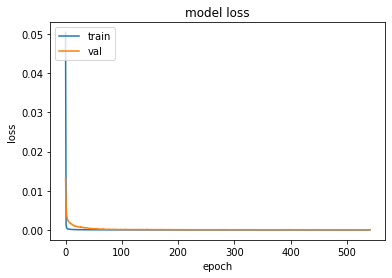

In [122]:
history = pd.read_csv("resources/model/history_sequential.csv")
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [123]:
train_acc = model.evaluate(x_train, y_train, verbose=0)
train_acc

3.016164009750355e-05

In [127]:
index = 8
sample = np.array([x_test[index]])

y_sample = scaler.inverse_transform([[y_test[index]] * 5 + [y_test[index]]])
print(y_sample[0][-1])
prediction = model.predict(sample)[0][0]
data = scaler.inverse_transform([[prediction] * 5 + [prediction]])
print(data[0][-1])
# print("train: ", mean_squared_error(y_train, prediction))


15132.54
1/1 [==============================] - 0s 45ms/step
15124.080331752299
